## Load Dependencies


In [23]:
%matplotlib notebook

import math
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import metrics


from libs.data_utils import HandDataset, ToTensor, Scale
from libs.layer_utils import flatten, random_weight, zero_weight
from libs.model_utils import (show_joints, makePosList, makeHeatMapOneHot,
                              makeMaps, generate_blw, ComputeLoss)
from libs.model import model, modelHeatmap, modelLocmap
from libs.lit_data import data2d, data3d, data3d2
                              
plt.ion() # interactive mode

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Parameters

In [22]:
params = {}

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    USE_GPU=False
print('Using device:', device)

batch_size = 2
num_joints = 21
image_size = 224
dtype = torch.float32
epsilon = 1e-8
g_heatmap_size = 9

b_idx = np.repeat(np.arange(batch_size), num_joints)
b_idx = torch.from_numpy(b_idx).long()
j_idx = np.array(list(np.arange(num_joints))*batch_size)
j_idx = torch.from_numpy(j_idx).long()

loss_scale = 1.0 / (batch_size * num_joints * g_heatmap_size**2 * 3)

params['batch_size'] = batch_size
params['num_joints'] = num_joints
params['image_size'] = image_size
params['dtype'] = dtype
params['epsilon'] = epsilon
params['device'] = device
params['USE_GPU'] = USE_GPU
params['g_heatmap_size'] = 9
params['b_idx'] = b_idx
params['j_idx'] = j_idx

blw = generate_blw(params)

Using device: cpu


## Load Dataset

In [13]:
transform = transforms.Compose([
    Scale(image_size, image_size),
    ToTensor(),
])

hand_train = HandDataset('toy_dataset.csv', transform=transform, train=True, device=device)
N = len(hand_train)
loader_train = DataLoader(hand_train, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.85))),
            drop_last=True)

hand_val = HandDataset('toy_dataset.csv', transform=transform, train=True)
loader_val = DataLoader(hand_val, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.85), int(N*0.9))),
                       drop_last=True)

hand_test = HandDataset('toy_dataset.csv', transform=transform, train=False)
loader_test = DataLoader(hand_test, batch_size=batch_size,
                         sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)),
                        drop_last=True)


## Load Model

In [14]:
it = '_e0_i3600'

model.load_state_dict(torch.load('models/model_param{}.pt'.format(it),map_location='cpu'))
modelHeatmap.load_state_dict(torch.load('models/modelHeatmap_param{}.pt'.format(it),map_location='cpu'))
modelLocmap.load_state_dict(torch.load('models/modelLocmap_param{}.pt'.format(it),map_location='cpu'))

## Evaluate Model

In [15]:
diff_2ds = []
diff_3ds = []


for idx, batch in enumerate(loader_test):
    image = batch['image'].float()
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    y_pred = model(image)
    h_pred = modelHeatmap(y_pred)
    l_pred = modelLocmap(y_pred)

    
    for i, img in enumerate(image):
        p2d, p3d = makePosList(h_pred[i], l_pred[i], params)
        img_npy = image[i].data.numpy().transpose((1,2,0))
        p2d_gt, p3d_gt = batch['pos_2d'][i], batch['pos_3d'][i]
        
        
        #show_joints(img_npy, p2d, p3d)
        #show_joints(img_npy, p2d_gt, p3d_gt)
        diff_2d = np.linalg.norm(p2d - p2d_gt, axis=1)
        diff_3d = np.linalg.norm(p3d - p3d_gt, axis=1)
        diff_2ds.append(diff_2d)
        diff_3ds.append(diff_3d)

diff_2ds = np.column_stack(diff_2ds)
diff_3ds = np.column_stack(diff_3ds)

## Literature Comparison

### 2D AUC Comparison

<IPython.core.display.Javascript object>


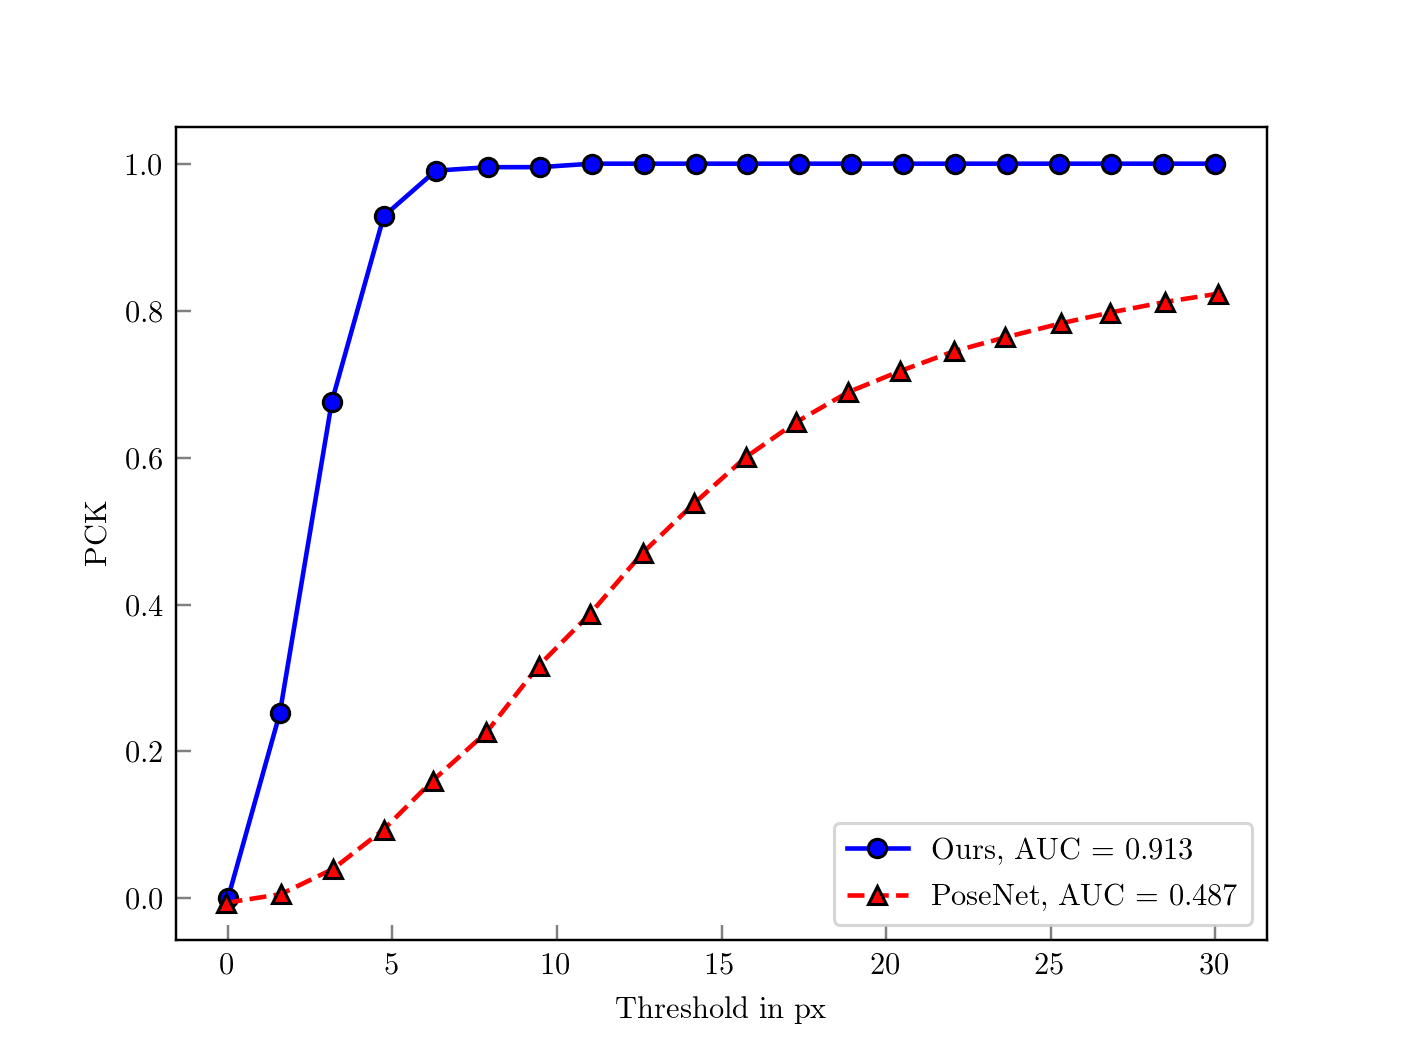

In [16]:
pcks = []

dists = np.linspace(0, 30, 20)

for dist in dists:
    pcks.append(np.mean(diff_2ds < dist))
    
auc = metrics.auc(dists, pcks)/dists[-1]
zauc = metrics.auc(data2d[:,0], data2d[:,1])/dists[-1]

fig = plt.figure()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax = fig.add_subplot(111)

ax.plot(dists, pcks, color='blue', marker='o', markeredgecolor='black',
       markeredgewidth=1)

ax.plot(data2d[:,0], data2d[:,1], color='red', marker='^', markeredgecolor='black',
       markeredgewidth=1, linestyle='--')


ax.tick_params(direction='in', length=5, color='grey')
ax.set_ylabel(r'PCK')
ax.set_xlabel(r'Threshold in px')
ax.legend(['Ours, AUC = {:.3f}'.format(auc),'PoseNet, AUC = {:.3f}'.format(zauc)])
plt.show()

### 3D AUC Comparison

<IPython.core.display.Javascript object>


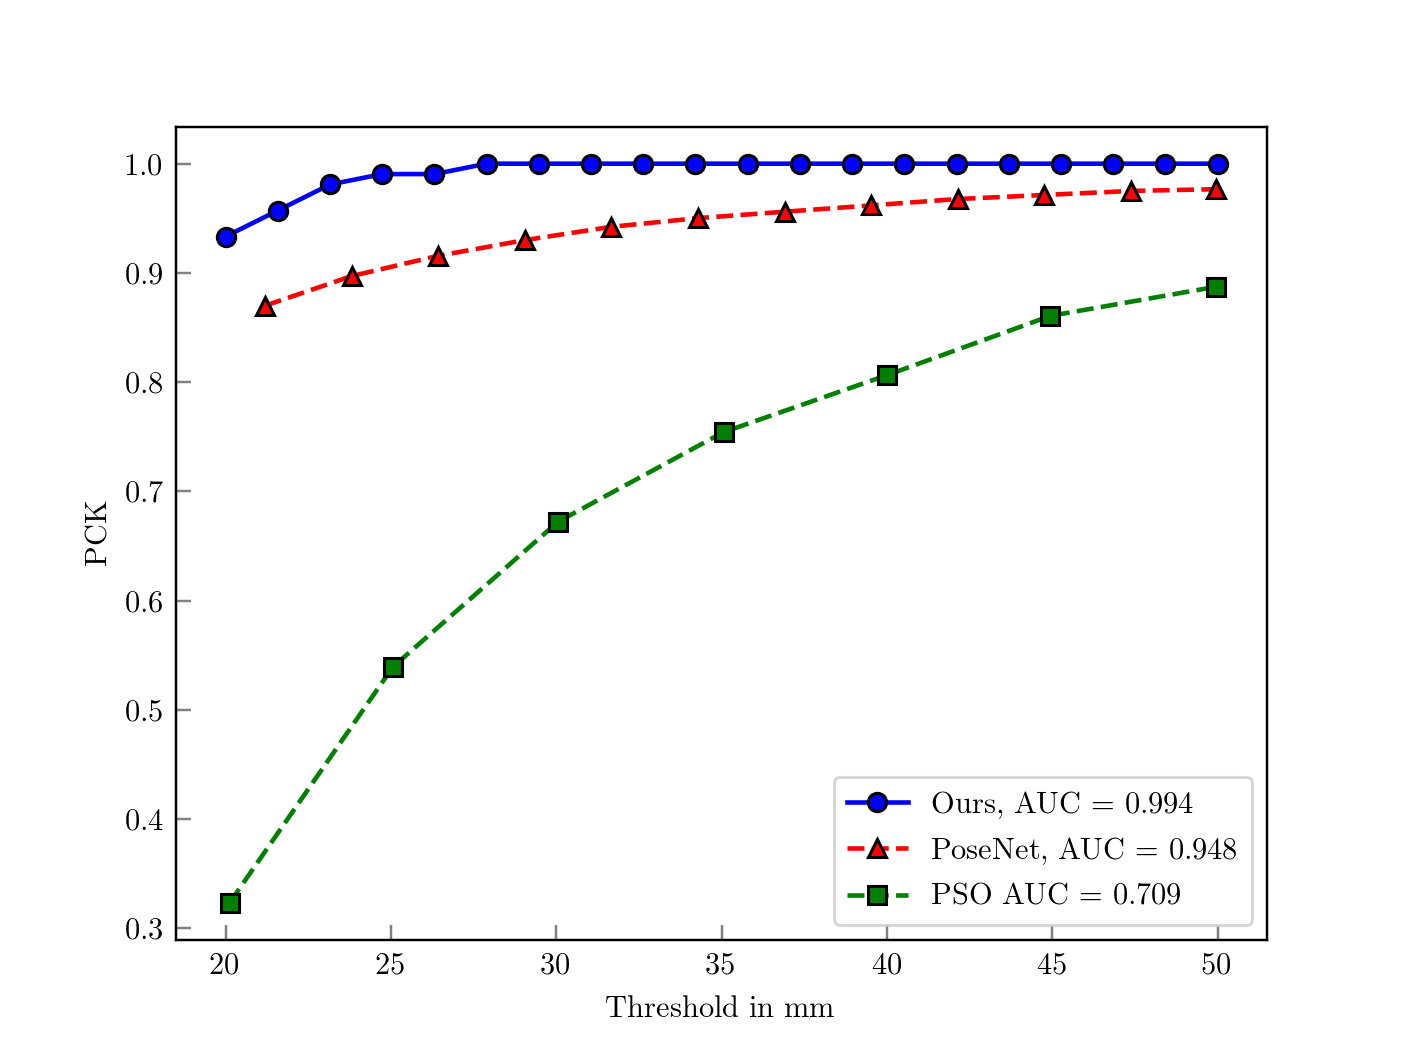

In [17]:
pcks = []

dists = np.linspace(20, 50, 20)
for dist in dists:
    pcks.append(np.mean(diff_3ds < dist))
    
auc = metrics.auc(dists, pcks)/(dists[-1]-dists[0])
zauc = metrics.auc(data3d[:,0], data3d[:,1])/(dists[-1]-dists[0])
pauc = metrics.auc(data3d2[:,0], data3d2[:,1])/(dists[-1]-dists[0])

fig = plt.figure()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

ax = fig.add_subplot(111)

ax.plot(dists, pcks, color='blue', marker='o', markeredgecolor='black',
       markeredgewidth=1)

ax.plot(data3d[:,0], data3d[:,1], color='red', marker='^', markeredgecolor='black',
       markeredgewidth=1, linestyle='--')

ax.plot(data3d2[:,0], data3d2[:,1], color='green', marker='s', markeredgecolor='black',
       markeredgewidth=1, linestyle='--')

ax.tick_params(direction='in', length=5, color='grey')
ax.set_ylabel('PCK')
ax.set_xlabel('Threshold in mm')
ax.legend(['Ours, AUC = {:.3f}'.format(auc),'PoseNet, AUC = 0.948'.format(zauc),
          'PSO AUC = 0.709'.format(pauc)])
plt.show()

<IPython.core.display.Javascript object>


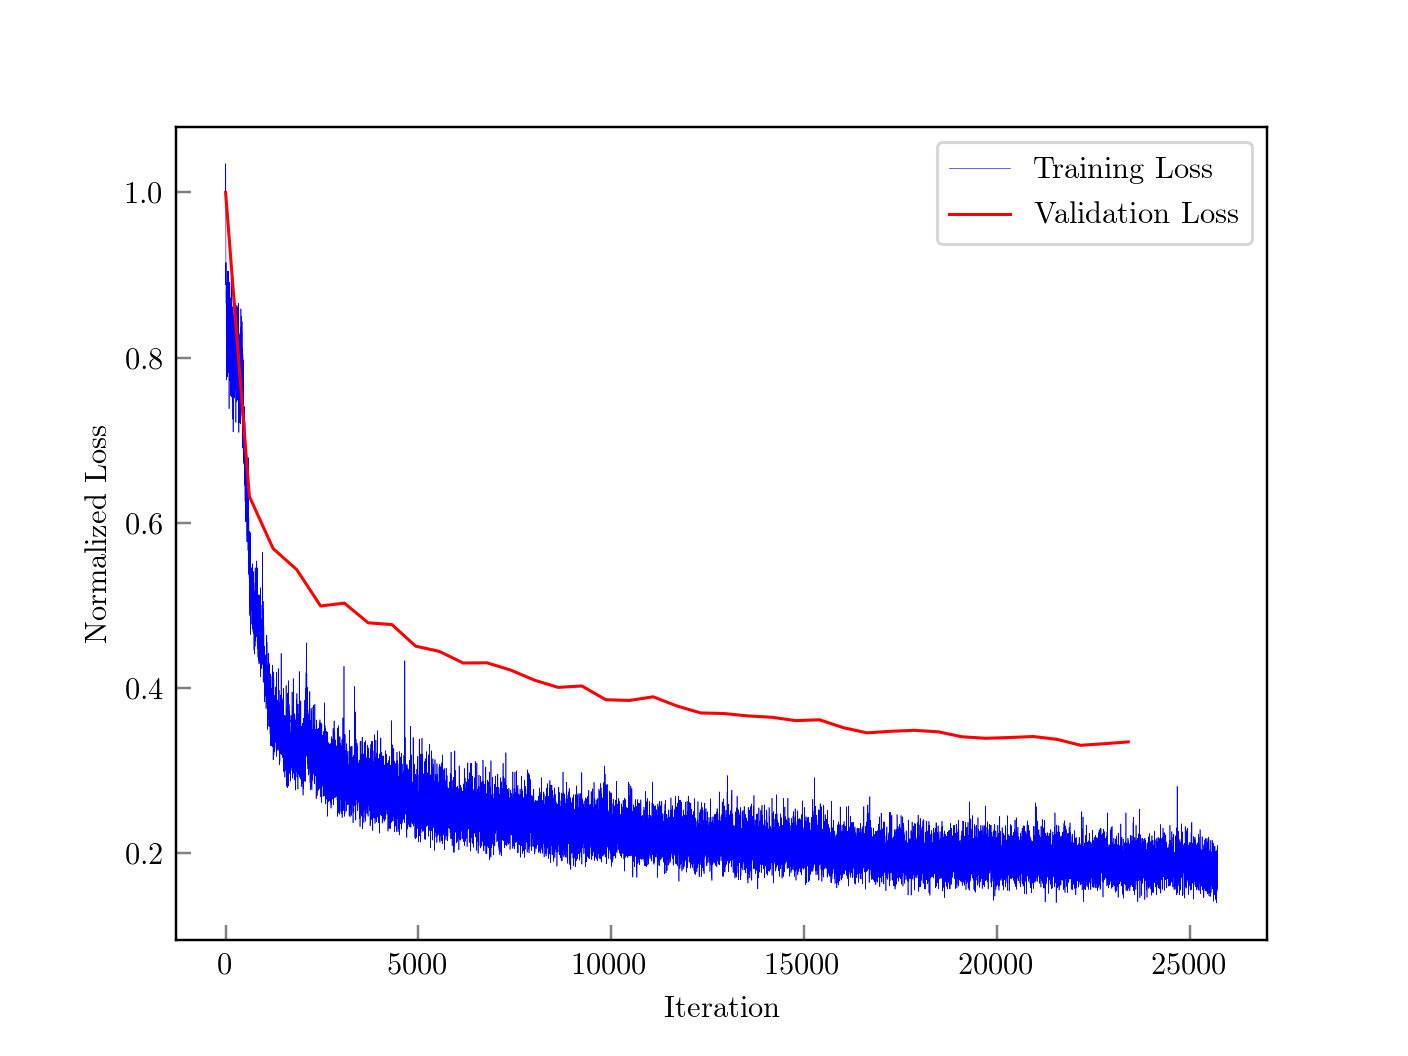

In [18]:
import pandas as pd

fig = plt.figure()

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
ax = fig.add_subplot(111)

df_log = pd.read_csv('./models/initial/trainlog.txt', header=None, delimiter=' ')
df_log = df_log.values
iters = np.arange(len(df_log))
loss = df_log[:, 2]/df_log[0,2]
ax.plot(iters, loss, color='blue', linewidth='0.2')

df_log = pd.read_csv('./models/initial/log.txt', header=None)
df_log = df_log.values
iters = np.linspace(0, len(df_log+1)*600, len(df_log+1))

loss = df_log[:,3]/df_log[0,3]
np.insert(loss, 0,1)
ax.plot(iters, loss, color='red',linewidth='1')


ax.tick_params(direction='in', length=5, color='grey')
ax.set_ylabel('Normalized Loss')
ax.set_xlabel('Iteration')
ax.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
print(pos2d_list)